## Setup

In [1]:
import sys
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as colors
import random
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import isuelogit as isl
import seaborn as sns
from datetime import datetime

In [2]:
from pesuelogit.visualizations import plot_heatmap_demands
from pesuelogit.models import compute_rr
from pesuelogit.networks import build_tntp_network
from pesuelogit.etl import get_design_tensor, add_period_id

In [ ]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

In [3]:
%load_ext autoreload
%autoreload 2

# Internal modules
from nesuelogit.models import NESUELOGIT, ODParameters, UtilityParameters, BPR, MLP, KernelConstraint, \
    GenerationParameters, train_val_split_by_links, train_kfold, compute_generated_trips, compute_generation_factors, \
    compute_benchmark_metrics, PolynomialLayer, regularization_kfold
from nesuelogit.visualizations import plot_predictive_performance, plot_metrics_kfold, \
    plot_top_od_flows_periods, plot_utility_parameters_periods, plot_flow_vs_traveltime, plot_performance_functions, \
    plot_annotate_r2, plot_flow_interaction_matrix, plot_parameters_kfold, plot_parameters, plot_convergence_estimates, \
    compute_total_trips_models
from nesuelogit.metrics import mse, btcg_mse, mnrmse, mape, r2_score, nrmse, zscore, nmse, z2score
from nesuelogit.utils import load_k_shortest_paths

In [5]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [6]:
# To report global runtime
t0_global = time.time()

## Build network

In [7]:
network_name = 'SiouxFalls'
network = build_tntp_network(network_name=network_name, folderpath=os.getcwd() + "/input/tntp/")

## Read OD matrix

In [8]:
# Load true demand matrix
Q = isl.reader.read_tntp_od(network_name=network_name, folderpath=os.getcwd() + "/input/tntp/")
network.load_OD(Q=Q)

Q_true = [network.OD.Q_true, 0.8*network.OD.Q_true]
q_true = tf.stack([network.OD.q_true.flatten(), 0.8*network.OD.q_true.flatten()], axis = 0)

Reading Q from external file
Matrix Q (24, 24) read in 0.0[s]                        

360600.0 trips were loaded among 528 o-d pairs


In [9]:
Q_historic = [isl.factory.random_disturbance_Q(i.copy(), sd=np.mean(i) * 0.1) for i in Q_true]
q_historic = [isl.networks.denseQ(i.copy()).flatten() for i in Q_historic]

Mean of nonzero entries in the original demand matrix:  683.0
Mean absolute difference between the nonzero entries of the noisy and original: 50.6
Approximated proportion change: 7.4%
Mean of nonzero entries in the original demand matrix:  546.4
Mean absolute difference between the nonzero entries of the noisy and original: 39.8
Approximated proportion change: 7.3%


In [10]:
Q_true

[array([[   0.,  100.,  100.,  500.,  200.,  300.,  500.,  800.,  500.,
         1300.,  500.,  200.,  500.,  300.,  500.,  500.,  400.,  100.,
          300.,  300.,  100.,  400.,  300.,  100.],
        [ 100.,    0.,  100.,  200.,  100.,  400.,  200.,  400.,  200.,
          600.,  200.,  100.,  300.,  100.,  100.,  400.,  200.,    0.,
          100.,  100.,    0.,  100.,    0.,    0.],
        [ 100.,  100.,    0.,  200.,  100.,  300.,  100.,  200.,  100.,
          300.,  300.,  200.,  100.,  100.,  100.,  200.,  100.,    0.,
            0.,    0.,    0.,  100.,  100.,    0.],
        [ 500.,  200.,  200.,    0.,  500.,  400.,  400.,  700.,  700.,
         1200., 1400.,  600.,  600.,  500.,  500.,  800.,  500.,  100.,
          200.,  300.,  200.,  400.,  500.,  200.],
        [ 200.,  100.,  100.,  500.,    0.,  200.,  200.,  500.,  800.,
         1000.,  500.,  200.,  200.,  100.,  200.,  500.,  200.,    0.,
          100.,  100.,  100.,  200.,  100.,    0.],
        [ 300.,  400

In [11]:
q_true

<tf.Tensor: shape=(2, 528), dtype=float64, numpy=
array([[ 100.,  100.,  500., ...,  500., 1100.,  700.],
       [  80.,   80.,  400., ...,  400.,  880.,  560.]])>

## Read paths

In [12]:
load_k_shortest_paths(network=network, k=3, update_incidence_matrices=True)

Paths were loaded and incidence matrix were built


## Read data

In [13]:
# Synthethic data which was generated under the assumption of path sets of size 2.
df = pd.read_csv(
    main_dir + '/input/network-data/' + network.key + '/links/' + network.key + '-link-data.csv')
df

,timepoint,link_key,tt_sd,s,period,traveltime,counts
0,1,"(0, 1, '0')",0.663287,0.608996,0,5.853573,5153.922893
1,1,"(0, 2, '0')",0.218225,0.823825,0,3.854738,5819.684611
2,1,"(1, 0, '0')",0.187173,0.182895,0,5.853705,5241.640666
3,1,"(1, 5, '0')",0.729779,0.786900,0,8.645683,6903.427287
4,1,"(2, 0, '0')",0.863313,0.311387,0,3.854562,5731.982463
...,...,...,...,...,...,...,...
22795,300,"(22, 21, '0')",0.118967,0.941838,2,7.387749,6971.091520
22796,300,"(22, 23, '0')",0.537956,0.516336,2,2.244349,4926.973355
22797,300,"(23, 12, '0')",0.054784,0.694868,2,8.478936,7654.000699
22798,300,"(23, 20, '0')",0.300521,0.431477,2,7.866051,8093.885465


In [14]:
# Generate synthetic node data
node_data = pd.DataFrame({'key': [node.key for node in network.nodes],
                          'income': np.random.rand(len(network.nodes)),
                          'population': np.random.rand(len(network.nodes))
                          })

## Exogenous features in utility function

In [15]:
_FEATURES_Z = ['tt_sd', 's']

## Training and validation sets

In [16]:
n_timepoints = len(df.timepoint.unique())
n_links = len(network.links)

# Add free flow travel times
df['tt_ff'] = np.tile([link.bpr.tf for link in network.links], n_timepoints)

In [17]:
period_feature = 'hour'
df = df.rename(columns = {'period': 'hour'})
df = add_period_id(df, period_feature=period_feature)

period_keys = df[[period_feature, 'period_id']].drop_duplicates().reset_index().drop('index', axis=1).sort_values(period_feature)
print(period_keys)

   hour  period_id
0     0          0
1     2          1


In [18]:
X = get_design_tensor(Z=df[_FEATURES_Z + ['period_id']], n_links=n_links, n_timepoints=n_timepoints )
Y = get_design_tensor(y=df[['traveltime', 'counts']], n_links=n_links, n_timepoints=n_timepoints)

# df_T = df[df.hour.isin([0, 5])]
df_T = df
XT = get_design_tensor(Z=df_T[_FEATURES_Z + ['period_id']], n_links=n_links, n_timepoints=n_timepoints )
YT = get_design_tensor(y=df_T[['traveltime', 'counts']], n_links=n_links, n_timepoints=n_timepoints)

In [19]:
_DTYPE = tf.float32

X, XT, Y, YT = [tf.cast(i, _DTYPE) for i in [X, XT, Y, YT]]

# Y_train, Y_val = train_val_split_by_links(Y.numpy(), val_size=0.05)
# YT_train, YT_val = train_val_split_by_links(YT.numpy(), val_size=0.05)

Y_train, Y_val = train_val_split_by_links(Y.numpy(), val_size=0)
YT_train, YT_val = train_val_split_by_links(YT.numpy(), val_size=0)

Y_val, YT_val = None, None


X_train, X_val = X, X
X_train, X_val, Y_train, Y_val = [tf.cast(i, _DTYPE) if i is not None else None for i in [X_train, X_val, Y_train, Y_val]]

XT_train, XT_val = XT, XT
XT_train, XT_val, YT_train, YT_val = [tf.cast(i, _DTYPE) if i is not None else None for i in [XT_train, XT_val, YT_train, YT_val]]

## Configuration

In [20]:
# Assume no access to historic OD matrix, thus, od weight is zero
_LOSS_WEIGHTS = {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1,
                 # 'regularizer_od': 0, 'regularizer_kernel': 0, 'regularizer_utility_ods': 0
                 }
#_LOSS_WEIGHTS = {'od': 0.5, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_EQUILIBRIUM_STAGE = True
_ALTERNATING_OPTIMIZATION = False

_LR = {'learning': 1e-1, 'equilibrium': 1e-2}

_BATCH_SIZE = 1
_EPOCHS = {'learning': 30, 'equilibrium': 30}
# _BATCH_SIZE = None
# _EPOCHS = {'learning': 2, 'equilibrium': 1}
_EPOCHS_PRINT_INTERVAL = {'learning': 1, 'equilibrium': 1}
_XTICKS_SPACING = 5

# With CPU
# _OPTIMIZERS = {'learning': tf.keras.optimizers.Adam(learning_rate=_LR['learning']),
#               'equilibrium': tf.keras.optimizers.Adam(learning_rate=_LR['equilibrium'])
#               }

# With GPU
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
               'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
               }

_RELATIVE_GAP = 1e-5

_LOSS_METRIC = z2score
# _LOSS_METRIC = zscore
# _LOSS_METRIC = nrmse
# _LOSS_METRIC = mse

## Models

In [21]:
models = {}
train_results_dfs = {}
val_results_dfs = {}

In [22]:
def create_mlp(network, homogenous = True, diagonal = False, adjacency_constraint = True,
               poly_order = 3, link_specific = False, symmetric = False,
               alpha_prior = 0.15, beta_prior = 4, pretrain = False, dtype =_DTYPE,
               max_traveltime_factor = None):

    return MLP(n_links=len(network.links),
               free_flow_traveltimes=[link.bpr.tf for link in network.links],
               capacities=[link.bpr.k for link in network.links],
               max_traveltime_factor = max_traveltime_factor,
               kernel_constraint=KernelConstraint(
                   link_keys=[(link.key[0], link.key[1]) for link in network.links],
                   dtype=dtype,
                   capacities=[link.bpr.k for link in network.links],
                   free_flow_traveltimes=[link.bpr.tf for link in network.links],
                   adjacency_constraint=adjacency_constraint,
                   # initial_values = np.eye(network.get_n_links())
                   diagonal= diagonal,
                   homogenous=homogenous,
                   symmetric = symmetric,
                   bounds_clipping = [0,10],
                   # min_diagonal_value = 1e-1
               ),
               trainable = True,
               polynomial_layer= PolynomialLayer(poly_order=poly_order,
                                                 trainable = True,
                                                 pretrain_weights= pretrain,
                                                 alpha_prior = alpha_prior, beta_prior=beta_prior,
                                                 kernel_constraint=tf.keras.constraints.NonNeg(),
                                                 link_specific = link_specific
                                                 ),
               alpha_relu = 0.1,
               depth=1,
               dtype=dtype)

def create_bpr(network, alpha_prior = 1, beta_prior = 1, dtype =_DTYPE, max_traveltime_factor = None):
    return BPR(keys=['alpha', 'beta'],
               # initial_values={'alpha': 0.15, 'beta': 4},
               # initial_values={'alpha': alpha_prior, 'beta': beta_prior}, # Consistent with MLP initialization
               initial_values={'alpha': alpha_prior * tf.ones(len(network.links), dtype = dtype),
                               'beta': beta_prior * tf.ones(len(network.links), dtype = dtype)},
               true_values={'alpha': 0.15, 'beta': 4},
               trainables={'alpha': True, 'beta':True},
               capacities = [link.bpr.k for link in network.links],
               free_flow_traveltimes =[link.bpr.tf for link in network.links],
               dtype = dtype,
               max_traveltime_factor = max_traveltime_factor,
               )

def create_model(network, model_key = 'tvgodlulpe', dtype=_DTYPE, n_periods=1, features_Z=_FEATURES_Z, historic_g=None,
                            performance_function=None, utility_parameters = None, od_parameters = None,
                            generation_parameters = None, generation: bool = True, utility: bool = False,
                            ):
    # optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    if utility_parameters is None:
        utility_parameters = UtilityParameters(features_Y=['tt'],
                                               features_Z=features_Z,
                                               # initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                               #                 'fixed_effect': np.zeros_like(network.links)},
                                               initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                                               'fixed_effect': np.zeros_like(network.links)},
                                               true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                               # trainables={'psc_factor': False, 'fixed_effect': False
                                               #     , 'tt': True, 'tt_sd': True, 's': True},
                                               trainables={'tt': utility, 'tt_sd': False, 's': False,
                                                           'psc_factor': False, 'fixed_effect': True},
                                               time_varying=True,
                                               dtype=dtype
                                               )

    # utility_parameters.random_initializer((-1,1),['tt','tt_sd','s'])
    # utility_parameters.random_initializer((0, 0), ['tt', 'tt_sd', 's'])

    if performance_function is None:
        # performance_function = create_bpr(network = network, dtype = dtype)
        performance_function = create_mlp(network = network, dtype = dtype)

    # generation_parameters = None

    if generation_parameters is None and generation:
        generation_parameters = GenerationParameters(
            # features_Z=['income', 'population'],
            initial_values={
                # 'income': 0,
                'fixed_effect': historic_g,
            },
            keys=['fixed_effect_od', 'fixed_effect_origin', 'fixed_effect_destination'],
            # true_values={'income': 0, 'fixed_effect': np.zeros_like(network.links)},
            # signs = {'income': '+','population': '+'},
            trainables={
                'fixed_effect': generation,
                # 'income': False, 'population': False,
                'fixed_effect_origin': False, 'fixed_effect_destination': False, 'fixed_effect_od': True
                # 'fixed_effect_origin': False, 'fixed_effect_destination': True, 'fixed_effect_od': False
            },
            pretrain_generation_weights=False,
            historic_g= historic_g,
            dtype=dtype
        )

    if od_parameters is None:
        od_parameters = ODParameters(key='od',
                                     # initial_values=network.q.flatten(),
                                     # true_values=network.q.flatten(),
                                     initial_values = tf.stack(q_true),
                                     historic_values = tf.stack(q_true),
                                     # historic_values={0: network.q.flatten()},
                                     # total_trips={0: np.sum(network.Q)},
                                     ods=network.ods,
                                     n_periods=n_periods,
                                     time_varying=True,
                                     trainable= not generation)

    model = NESUELOGIT(
        key=model_key,
        network=network,
        dtype=dtype,
        utility=utility_parameters,
        performance_function=performance_function,
        generation=generation_parameters,
        od=od_parameters,
        n_periods=n_periods
    )

    return model, {'utility_parameters': utility_parameters, 'generation_parameters': generation_parameters,
                   'od_parameters': od_parameters, 'performance_function': performance_function}

## a) Equilibrium (SUELOGIT)

In [23]:
print('Gradient based SUELOGIT')

# Note: Here we assume we know the True OD matrix and the scale of the second period is obtained from the link flow data. Otherwise,
# the link flows and travel times obtained at equilibrium will not necessarily match the observed data.

# To report runtime
t0 = time.time()

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generation_factors = compute_generation_factors(period_column=X[:, :, -1, None].numpy(),
                                                flow_column=Y[:, :, 1, None].numpy(), reference_period=0)
# generation_factors = np.array([1,1])

generated_trips = compute_generated_trips(q=isl.networks.denseQ(Q).flatten()[np.newaxis, :],
                                          ods=network.ods)

suelogit, _ = create_model(network = network,
                                      model_key = 'suelogit',
                                                n_periods= n_periods,
                                                performance_function = BPR(keys=['alpha', 'beta'],
                                                                           initial_values={'alpha': 0.15, 'beta': 4},
                                                                           trainables={'alpha': True, 'beta':True},
                                                                           capacities = [link.bpr.k for link in network.links],
                                                                           free_flow_traveltimes =[link.bpr.tf for link in network.links],
                                                                           dtype = _DTYPE
                                                                           ),
                                                utility_parameters = UtilityParameters(features_Y=['tt'],
                                                                                       features_Z=_FEATURES_Z,
                                                                                       initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                                                                                       'fixed_effect': np.zeros_like(network.links)},
                                                                                       time_varying=True,
                                                                                       dtype=_DTYPE
                                                                                       ),
                                                od_parameters = ODParameters(key='od',
                                                                             initial_values= generation_factors.values[:,np.newaxis]*network.q.flatten(),
                                                                             ods=network.ods,
                                                                             n_periods=n_periods,
                                                                             time_varying=True,
                                                                             trainable=False),
                                                generation = False,
                                                historic_g= generation_factors.values[:,np.newaxis]*generated_trips)

train_results_dfs['suelogit'], val_results_dfs['suelogit'] = suelogit.compute_equilibrium(
    XT_train,
    node_data=node_data,
    # loss_metric=_LOSS_METRIC,
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-2),
    batch_size=1,
    loss_weights={'equilibrium': 1},
    threshold_relative_gap=1e-5,
    pretrain_link_flows = True,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS['learning'] + _EPOCHS['equilibrium'])

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

Gradient based SUELOGIT

Computing gradient based equilibrium

Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: 1e-05
training set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

0/60: train mse=8.4e+07, theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.86e+05], avg alpha=0.15, avg beta=4, lambda eq=1, relative gap=0.65, train equilibrium loss=8.4e+07, time: 0.1

1/60: train mse=7.3e+07, theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.86e+05], avg alpha=0.15, avg beta=4, lambda eq=1, relative gap=0.59, train equilibrium loss=7.3e+07, time: 5.5

2/60: train mse=6.3e+07, theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.86e+05], avg alpha=0.15

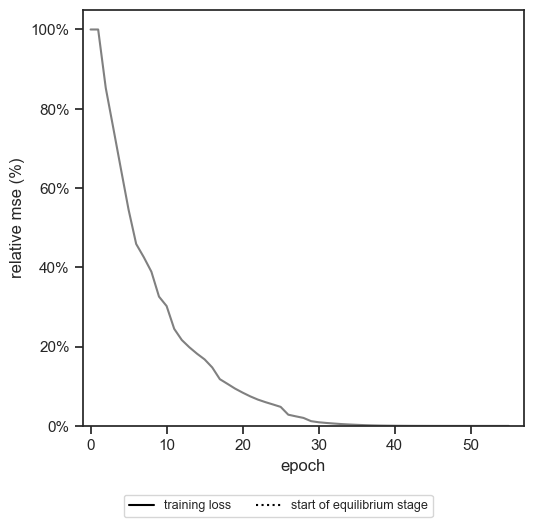

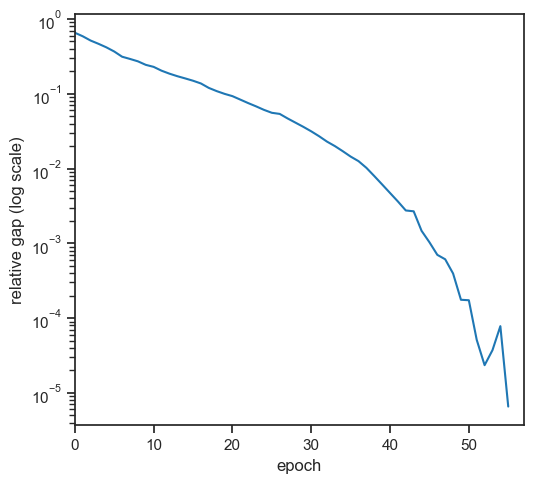

In [24]:
fig, ax = plot_predictive_performance(train_losses=train_results_dfs['suelogit'], val_losses=val_results_dfs['suelogit'],
                            xticks_spacing=10, curves=['equilibrium'])

ax.get_legend().remove()

plt.tight_layout()

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-suelogit.png')

plt.show()

train_results_estimates, train_results_losses = suelogit.split_results(results=train_results_dfs['suelogit'])
val_results_estimates, val_results_losses = suelogit.split_results(results=val_results_dfs['suelogit'])

fig, ax = plot_convergence_estimates(
    estimates=train_results_losses.assign(
        relative_gap=np.abs(train_results_losses['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=10)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-suelogit.png')

plt.show()

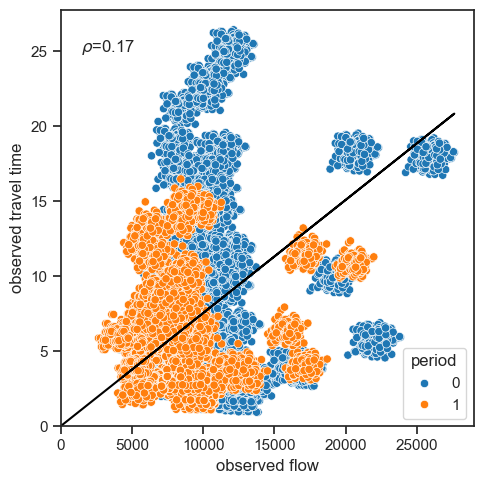

In [25]:
fig, ax = plot_flow_vs_traveltime(model = suelogit,
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False,
                        only_observed = True,
                        )

ax.legend(loc='lower right', title = 'period')

ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime.png')

plt.show()

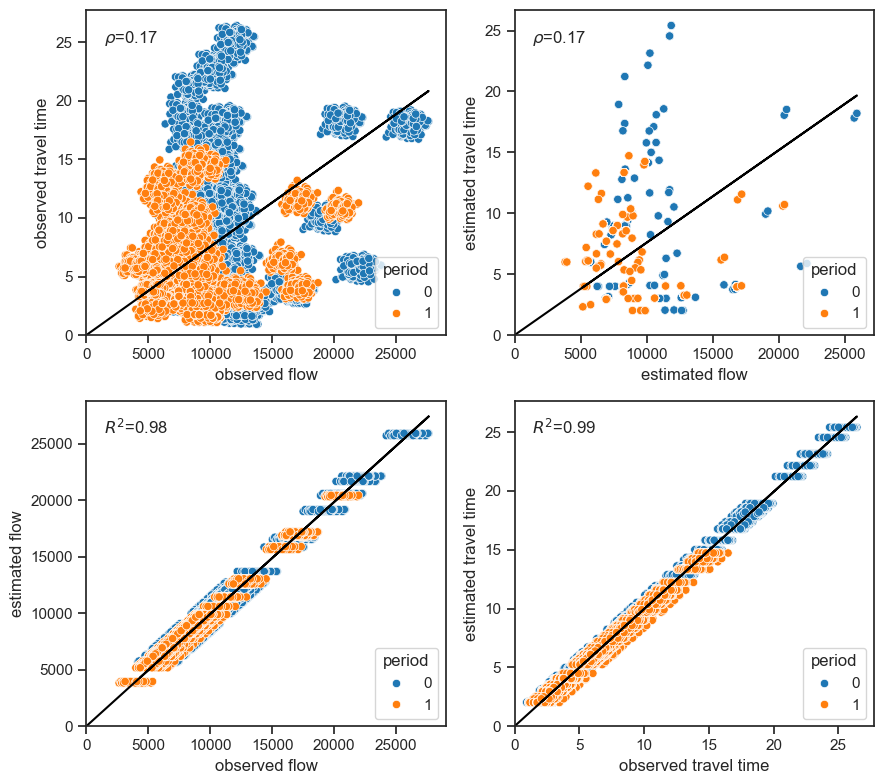

In [26]:
fig, axs = plot_flow_vs_traveltime(model = suelogit,
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)
    ax.legend(loc='lower right', title = 'period')

# axs[1,1].set_xlim(xmin=-1)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-suelogit.png')

plt.show()

## b) Benchmark (TVODLULPE)

In [27]:
print('\ntvodlulpe: Time specific utility and OD, link performance parameters, no historic OD')

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = compute_generated_trips(q=tf.stack(q_historic), ods=network.ods)


tvodlulpe: Time specific utility and OD, link performance parameters, no historic OD


In [28]:

t0 = time.time()

models['tvodlulpe'], _ = create_model(
    model_key = 'tvodlulpe',
    n_periods= n_periods, network = network,
    historic_g= generated_trips,
    performance_function = create_bpr(network = network, dtype = _DTYPE, max_traveltime_factor = None),
    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=_FEATURES_Z,
                                           # initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                           #                 'fixed_effect': np.zeros_like(network.links)},
                                           initial_values={
                                               # 'tt': -1e-1, 'tt_sd': -1e-1, 's': -1e-1, 'psc_factor': 0,
                                               'tt': -1, 'tt_sd': -1, 's': -1, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(network.links)},
                                           # signs={'tt': '-', 'tt_sd': '-', 's': '-'},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           time_varying=True,
                                           dtype=_DTYPE,
                                           trainables={'tt': True, 'tt_sd': True, 's': True,
                                                       'psc_factor': False, 'fixed_effect': True},
                                           ),
    od_parameters = ODParameters(key='od',
                         #initial_values= generation_factors.values[:,np.newaxis]*network.q.flatten(),
                         initial_values = tf.stack(q_historic),
                         historic_values={0: q_historic[0], 1:q_historic[1]},
                         ods=network.ods,
                         n_periods=n_periods,
                         time_varying=True,
                         trainable=True),
    generation = False,
    utility  = True,
)

train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

models['tvodlulpe'].save_weights(models['tvodlulpe']._filepath_weights)


Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: 1e-05
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
validation set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

Learning stage: 30 epochs

0/60: train mse=1.9e+07, train mse traveltime=10, train mape traveltime=34.4 train mse flow=1.9e+07, train mape flow=28.3, theta = [-1. -1. -1.], avg rr = 1.00, avg theta fixed effect = 0, loss prop od=2.4e-09, total trips=[3.62e+05 2.87e+05], avg alpha=1, avg beta=1, lambda eq=1, relative gap=0.38, train equilibrium loss=3.9e+07, time: 0.1

1/60: train mse=1.9e+06, train mse traveltime=3, train mape traveltime=11.0 train mse flow=5.6e+06, train mape flow=13.1, theta = [-0.427 -2.638 -1.777], avg rr = 6.17, avg theta fixed effect = -0.34, loss prop

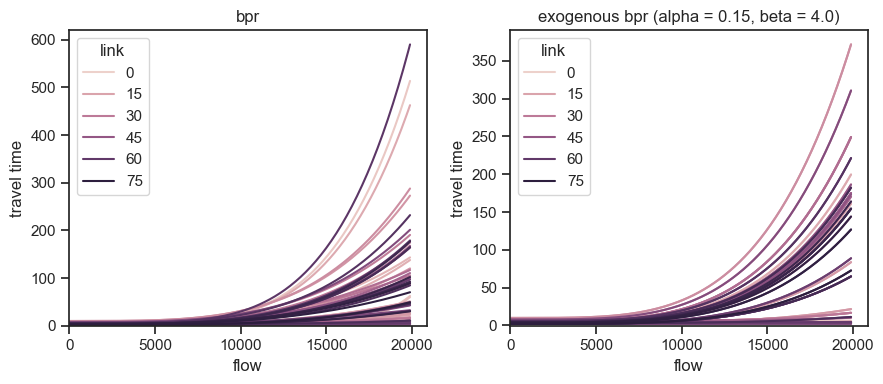

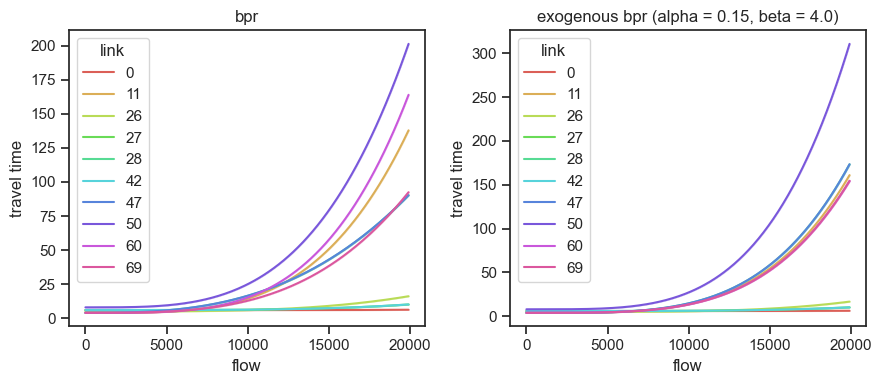

In [29]:
flow_range = range(0, 20000, 100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = network,
                                      marginal = False,
                                      # alpha=models['tvodlulpe'].performance_function.alpha,
                                      # beta=models['tvodlulpe'].performance_function.beta,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      # alpha=0.15,
                                      # beta=4,
                                      sharey = sharey,
                                      flow_range = flow_range
                                      # selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)
                                      )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)
    ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/experiments/siouxfalls-comparison-all-link-performance-functions-tvodlulpe.png')

plt.show()

selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=network,
                           marginal=True,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()


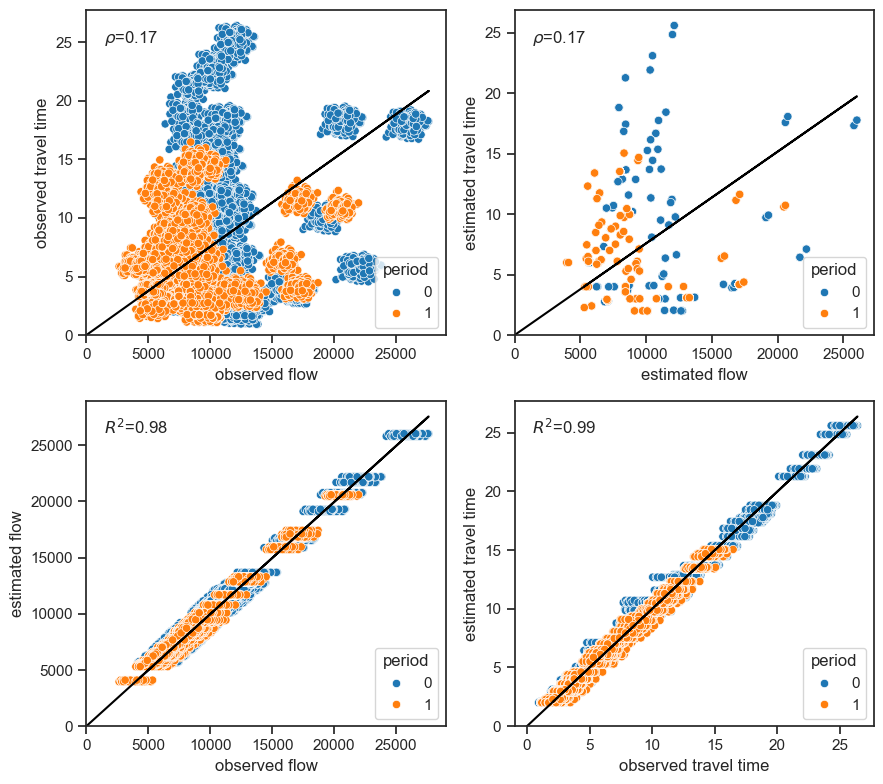

In [30]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                                   observed_traveltime=Y[:, :, 0],
                                   observed_flow= Y[:,:,1],
                                   period_col = X[:,:,-1].numpy().astype(int).flatten(),
                                   # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                                   all_metrics = False
                                   )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)
    ax.legend(loc='lower right', title = 'period')

axs[1,1].set_xlim(xmin=-1)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-tvodlulpe.png')

plt.show()

(<Figure size 550x500 with 1 Axes>, <Axes: xlabel='epoch', ylabel='mape'>)

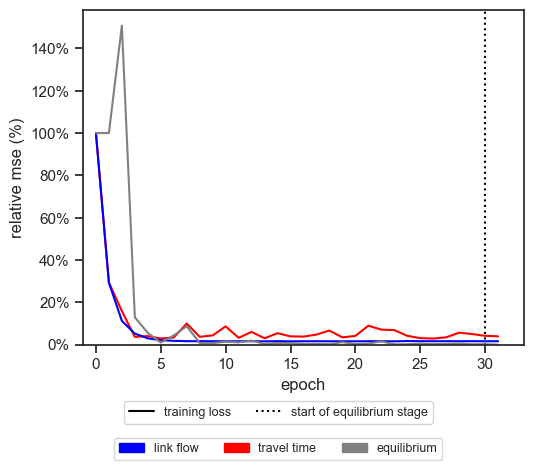

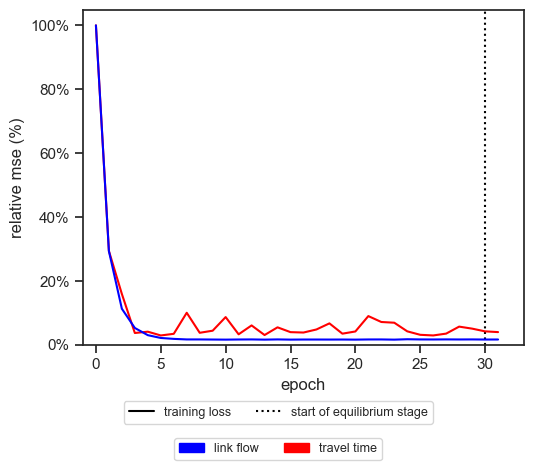

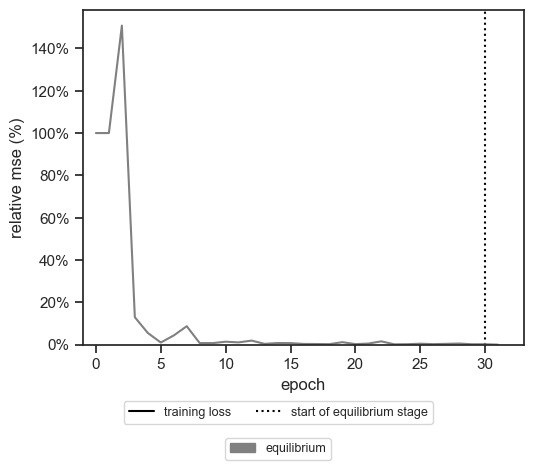

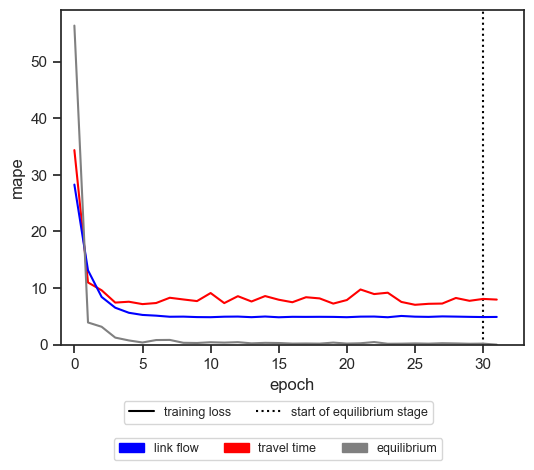

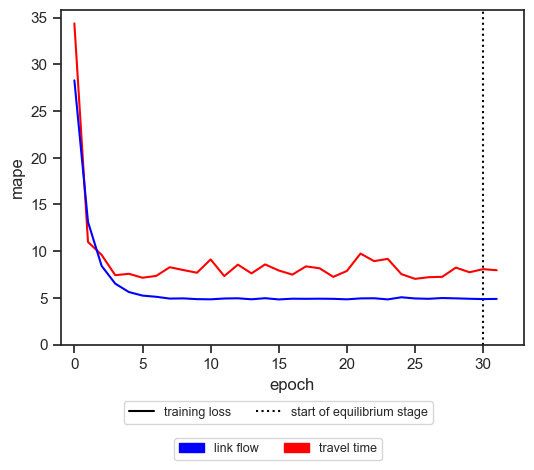

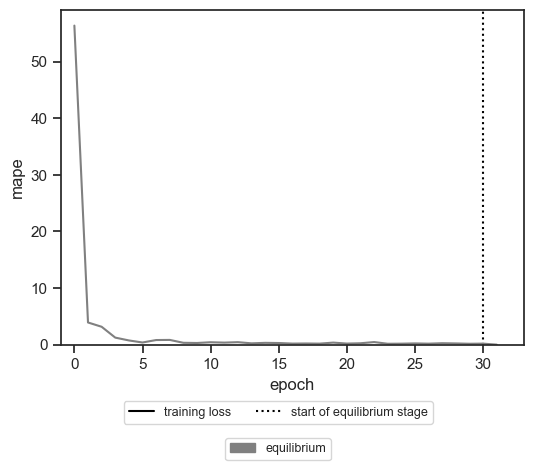

In [31]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            # curves = ['link flow', 'travel time'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            curves = ['link flow', 'travel time'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            curves = ['equilibrium'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves = ['link flow', 'travel time'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves = ['link flow', 'travel time'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')

plt.savefig('output/figures/experiments/siouxfalls-mape-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves = ['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')

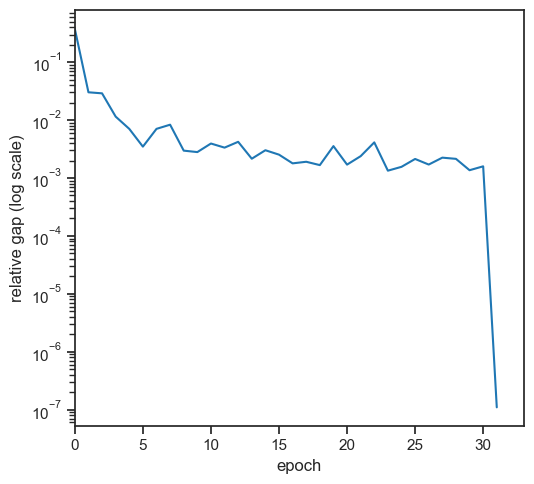

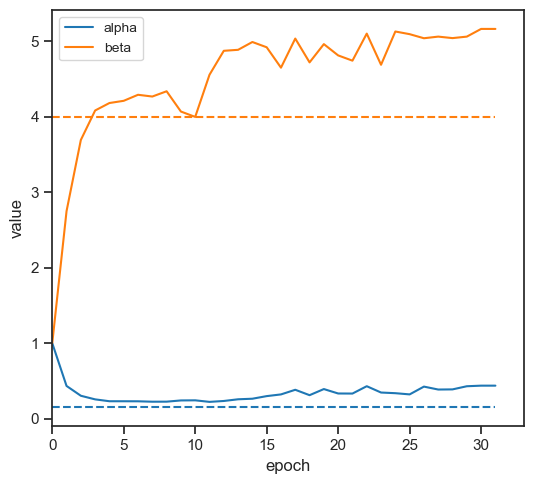

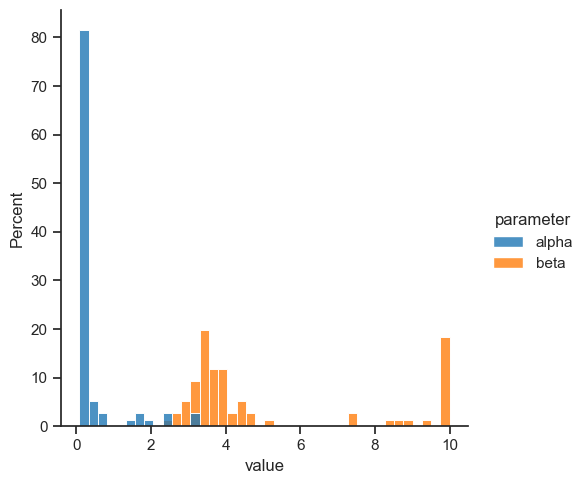

parameter
alpha    0.437124
beta     5.162848
Name: value, dtype: float32


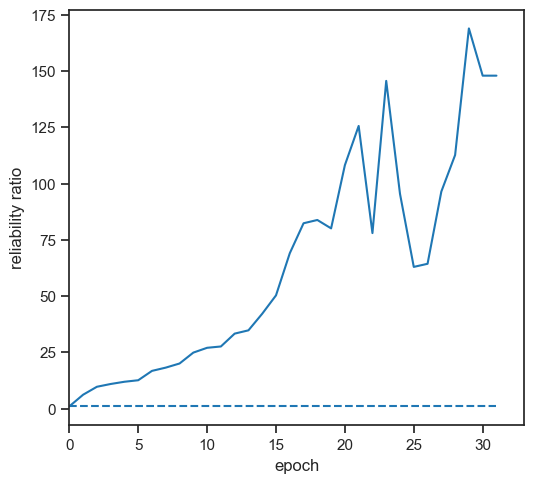

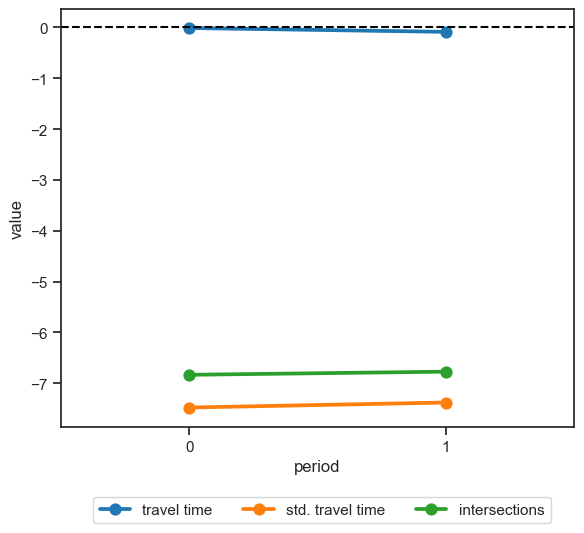

   period         parameter     value    group
0       0       travel time -0.012194  utility
1       1       travel time -0.088199  utility
2       0  std. travel time -7.478033  utility
3       1  std. travel time -7.379061  utility
4       0     intersections -6.833942  utility
5       1     intersections -6.772167  utility


In [32]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-tvodlulpe.png')

plt.show()


plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                           xticks_spacing=_XTICKS_SPACING,
                           true_values=models['tvodlulpe'].performance_function.parameters.true_values,
                           )

plt.show()
plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                                  'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

#sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", ax = ax)

# sns.displot(plot_data, x="value", col="parameter", kind="hist", hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.25)
sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.25)

plt.savefig('output/figures/experiments/siouxfalls-distribution-link-performance-parameters-tvodlulpe.png')

plt.show()

print(plot_data.groupby('parameter')['value'].mean())

fig, ax = plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe']. \
                           assign(rr=train_results_dfs['tvodlulpe']['tt_sd'] / train_results_dfs['tvodlulpe']['tt'])[['epoch', 'rr']],
                           true_values={'rr': models['tvodlulpe'].utility.true_values['tt_sd']/models['tvodlulpe'].utility.true_values['tt']},
                           xticks_spacing=_XTICKS_SPACING)
# ax.legend(loc = 'lower right')
ax.get_legend().remove()
ax.set_ylabel("reliability ratio")
plt.show()

# Utility by period

theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'rr': 'reliability ratio'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections'})

fig, ax = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig(f'output/figures/experiments/siouxfalls-utility-periods-tvodlulpe.png')

plt.show()

print(theta_df)

# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
# theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False)
#
# rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': period_feature, 0: 'rr'})
#
# sns.lineplot(data=rr_df, x=period_feature, y="rr")
#
# plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:814: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


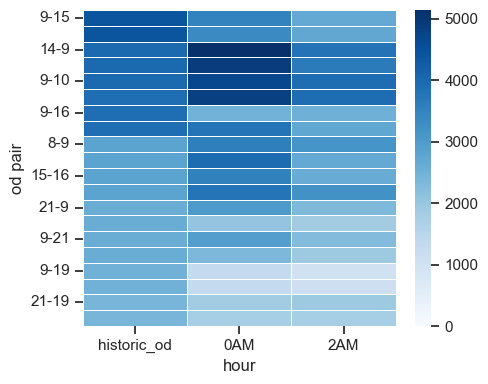

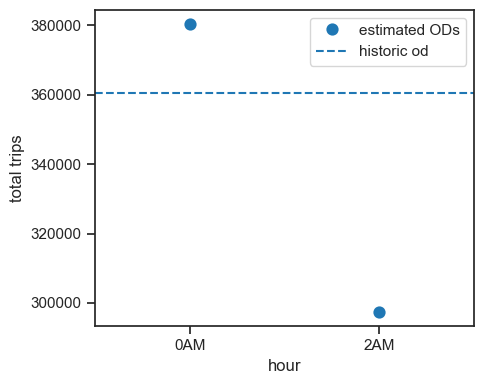

period 0

correlation: 0.8572784727752117


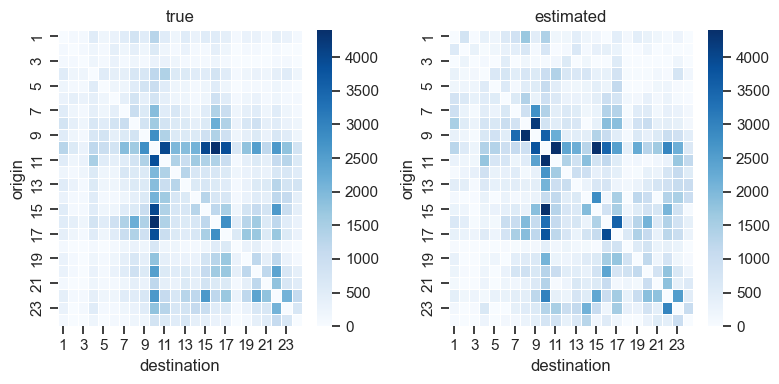

period 1

correlation: 0.8989867660309878


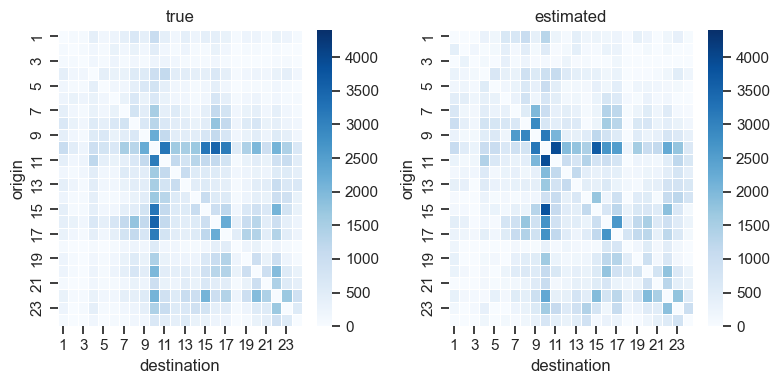

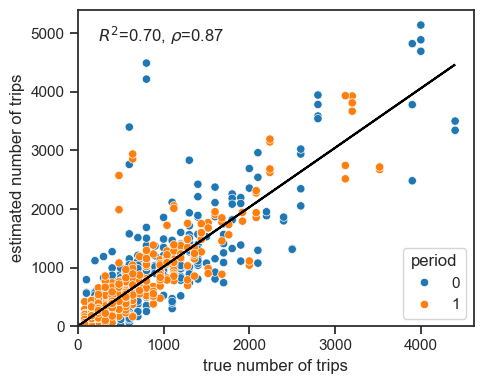

In [33]:
# Plot heatmap with flows of top od pairs
_ = plot_top_od_flows_periods(models['tvodlulpe'], period_keys=period_keys, period_feature=period_feature, top_k=20,
                          historic_od=network.q.flatten())

plt.show()

# Plot heatmaps with OD matrix

estimated_Q = models['tvodlulpe'].Q.numpy()
plot_data = pd.DataFrame()

for period in range(estimated_Q.shape[0]):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'estimated': estimated_Q[period]}  # 'historic': Q_historic,

    rho_val, p = sp.stats.pearsonr(Qs["true"].flatten(), Qs["estimated"].flatten())
    print(f'correlation: {rho_val}')

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))
    plt.show()

    plot_data = pd.concat([plot_data, pd.DataFrame({'true': Qs['true'].flatten(), 'estimated':Qs['estimated'].flatten(),
                                                    'period': period})])

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
sns.scatterplot(data=plot_data, x='true', y='estimated', hue = 'period', ax = ax)
plot_annotate_r2(ax=ax, x=plot_data['true'], y=plot_data['estimated'], intercept = False, r2 = True, rho = True)
ax.set_xlabel('true number of trips')
ax.set_ylabel('estimated number of trips')
ax.legend(loc='lower right', title = 'period')
ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig(f'output/figures/experiments/siouxfalls-scatter-ode-tvodlulpe.png')

plt.show()

In [34]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

if models['tvodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -0.050196223, 'tt_sd': -7.428547, 's': -6.803055}
alpha =  0.44, beta  =  5.16
Avg abs diff of observed and estimated OD:  232.42
Avg observed OD:  682.95


In [35]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')

if YT_val is not None:
    metrics_df = pd.concat([metrics_df,
                            models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                                     X=XT_val, Y=YT_val).assign(dataset='validation'),
                            compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
                                                      Y=YT_val).assign(
                                dataset='benchmark')
                            ])

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                  mape     mse   r2
component   dataset                      
equilibrium training 1.1e-05 2.8e-06    1
flow        training     4.9 3.1e+05 0.98
traveltime  training       8     0.4 0.99


## c) TVGODLULPE

In [36]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = compute_generated_trips(q=tf.stack(q_historic), ods=network.ods)

In [37]:
def create_tvgodlulpe_model():
    return create_model(
        model_key = 'tvgodlulpe',
        n_periods= n_periods, network = network,
        historic_g= generated_trips,
        utility_parameters = UtilityParameters(features_Y=['tt'],
                                               features_Z=_FEATURES_Z,
                                               initial_values={
                                                   'tt': -1e-0, 'tt_sd': -1e-0, 's': -1e-0, 'psc_factor': 0,
                                                   # 'tt': -1e-1, 'tt_sd': -1e-1, 's': -1e-1, 'psc_factor': 0,
                                                               'fixed_effect': np.zeros_like(network.links)},
                                               true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                               # signs={'tt': '-', 'tt_sd': '-', 's': '-'},
                                               time_varying=True,
                                               dtype=_DTYPE,
                                               trainables={'tt': True, 'tt_sd': True, 's': True,
                                                           'psc_factor': False, 'fixed_effect': True},
                                               ),
        # For fair comparison against bpr, the interaction parameter is assumed homogenous
        performance_function = create_mlp(network = network, adjacency_constraint = True,
                                          symmetric = False, diagonal = False, homogenous = False,
                                          poly_order = 3,
                                          # alpha_prior = 1, beta_prior = 1,
                                          pretrain = False,
                                          dtype = _DTYPE, max_traveltime_factor=None),
        od_parameters = ODParameters(key='od',
                                     #initial_values= generation_factors.values[:,np.newaxis]*network.q.flatten(),
                                     initial_values = tf.stack(q_historic),
                                     historic_values={0: q_historic[0], 1:q_historic[1]},
                                     ods=network.ods,
                                     n_periods=n_periods,
                                     time_varying=True,
                                     trainable=True),
        generation = True,
        utility  = True,

    )

models['tvgodlulpe'], _ = create_tvgodlulpe_model()

In [ ]:
t0 = time.time()

train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    # batch_size=None,
    loss_weights=_LOSS_WEIGHTS,
    #loss_weights = {'od': 0, 'theta': 0, 'traveltime': 1e0, 'flow': 1, 'equilibrium': 1},
    loss_metric= _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    # epochs={'learning':1, 'equilibrium': 0},
    epochs=_EPOCHS
)

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

models['tvgodlulpe'].save_weights(models['tvgodlulpe']._filepath_weights)


Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: 1e-05
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
validation set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

Learning stage: 30 epochs

0/60: train mse=5.9e+07, train mse traveltime=5.5e+04, train mape traveltime=768.7 train mse flow=3.6e+07, train mape flow=44.0, theta = [-1. -1. -1.], avg rr = 1.00, avg theta fixed effect = 0, loss prop od=2.8e+05, total trips=[3.62e+05 2.87e+05], polynomial weights: [1.0e+00 1.0e+00 1.0e+00], lambda eq=1, relative gap=0.63, train equilibrium loss=1.4e+08, time: 0.1

1/60: train mse=4e+06, train mse traveltime=9.7, train mape traveltime=16.1 train mse flow=1.2e+07, train mape flow=20.5, theta = [-0.154 -3.365 -3.294], avg rr = 21.89, avg theta 

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )
for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)
    ax.legend(loc='lower right', title = 'period')

axs[1,1].set_xlim(xmin=-1)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-tvgodlulpe.png')

plt.show()

In [ ]:
flow_range = range(0, 20000, 100)
sharey = False

In [ ]:
fig, axs = plot_performance_functions(model = models['tvgodlulpe'],
                                      network = network,
                                      marginal = False,
                                      # alpha=models['tvgodlulpe'].performance_function.polynomial_layer.alpha_prior*np.ones(network.get_n_links()),
                                      # beta=models['tvgodlulpe'].performance_function.polynomial_layer.beta_prior*np.ones(network.get_n_links()),
                                      # alpha=models['tvodlulpe'].performance_function.alpha,
                                      # beta=models['tvodlulpe'].performance_function.beta,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range

                                      # selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)
                                      )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)
    ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/experiments/siouxfalls-comparison-all-link-performance-functions-tvgodlulpe.png')

plt.show()

# plot_performance_functions(model = models['tvgodlulpe'],
#                                network = network,
#                                marginal = True,
#                                alpha=models['tvgodlulpe'].performance_function.polynomial_layer.alpha_prior*np.ones(network.get_n_links()),
#                                beta=models['tvgodlulpe'].performance_function.polynomial_layer.beta_prior*np.ones(network.get_n_links()),
#                                # alpha=0.15*np.ones(network.get_n_links()),
#                                # beta=4*np.ones(network.get_n_links()),
#                                sharey = sharey,
#                                flow_range = flow_range
#                                # selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)
#                                )
#
# plt.show()

In [ ]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

# Plot with bpr used the priors of the BPR parameters used to pretrain the MLP

plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=False,
                           # alpha=models['tvgodlulpe'].performance_function.polynomial_layer.alpha_prior*np.ones(network.get_n_links()),
                           # beta=models['tvgodlulpe'].performance_function.polynomial_layer.beta_prior*np.ones(network.get_n_links()),
                           # alpha=models['tvodlulpe'].performance_function.alpha,
                           # beta=models['tvodlulpe'].performance_function.beta,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=False,
                           # alpha=0.15*np.ones(network.get_n_links()),
                           # beta=4*np.ones(network.get_n_links()),
                           # alpha=models['tvodlulpe'].performance_function.alpha,
                           # beta=models['tvodlulpe'].performance_function.beta,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

# Marginal increases show that function are still monotonically increasing
plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=True,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

In [ ]:
# Experiments assume no link flow interactions and that all parameters mapping flow to travel time have the same value.
# With this approach, the parameter becomes almost equal to alpha = 0.15.
# weights = models['tvgodlulpe'].performance_function.weights[1].numpy()
if models['tvgodlulpe'].performance_function.kernel_constraint.homogenous:
    weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].parameter.numpy()
else:
    # weights_interaction = models['tvgodlulpe'].performance_function.weights[-1].numpy()
    weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()

initial_weights = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()

plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights,
    #flow_interaction_matrix= np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    #masking_matrix = np.where(initial_weights>0, 1, -1)*np.where(initial_weights==0, 0, 1),
    # vmin = -0.2, vmax = 0.2
    vmin = -1, vmax = 1
)
plt.savefig('output/figures/experiments/siouxfalls-kernel-link-performance-functions-tvgodlulpe.png')

plt.show()

print(f'Final weights:\n {weights_interaction}')
print(f'\nInitial weights:\n',initial_weights)

In [ ]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

plot_data['value_abs'] = plot_data.value.abs()

# sns.displot(data = plot_data, x="value", col="type", kind="hist", hue = "type", alpha=0.8, facet_kws=dict(sharey=False, sharex = False))
# plt.show()

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha = 0.8, multiple="stack", ax = ax)
sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, 
            facet_kws=dict(sharey=False, sharex = False), binwidth = 0.25)
plt.xlim(-0.5, 10)
plt.savefig('output/figures/experiments/siouxfalls-distribution-link-performance-parameters-tvgodlulpe.png')
plt.show()
print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [ ]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

In [ ]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'],
                            val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                            xticks_spacing=_XTICKS_SPACING,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'],
                            # val_losses=val_results_dfs['tvgodlulpe'],
                            curves = ['link flow', 'travel time'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'],
                            val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                            xticks_spacing=_XTICKS_SPACING,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])


plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'][train_results_dfs['tvgodlulpe'].epoch>0],
                                      val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                                      xticks_spacing=_XTICKS_SPACING,
                                      # curves = ['link flow', 'travel time'],
                                      epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                                      yaxis_label='mape')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'][train_results_dfs['tvgodlulpe'].epoch>0],
                                      val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                                      xticks_spacing=_XTICKS_SPACING,
                                      curves = ['link flow', 'travel time'],
                                      epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                                      yaxis_label='mape')

plt.savefig('output/figures/experiments/siouxfalls-mape-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'][train_results_dfs['tvgodlulpe'].epoch>0],
                                      val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                                      xticks_spacing=_XTICKS_SPACING,
                                      curves=['equilibrium'],
                                      epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                                      yaxis_label='mape')

plt.show()

In [ ]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-tvgodlulpe.png')

plt.show()

fig, ax = plot_convergence_estimates(estimates=train_results_dfs['tvgodlulpe']. \
                                     assign(rr=train_results_dfs['tvgodlulpe']['tt_sd'] / train_results_dfs['tvgodlulpe']['tt'])[['epoch', 'rr']],
                                     true_values={'rr': models['tvgodlulpe'].utility.true_values['tt_sd']/models['tvgodlulpe'].utility.true_values['tt']},
                                     xticks_spacing=_XTICKS_SPACING)
# ax.legend(loc = 'lower right')
ax.get_legend().remove()
ax.set_ylabel("reliability ratio")
plt.show()

# Utility by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
#     replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'rr': 'reliability ratio'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections'})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig(f'output/figures/experiments/siouxfalls-utility-periods-tvgodlulpe.png')

plt.show()

print(theta_df)

In [ ]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature=period_feature, top_k=20,
                          historic_od=network.q.flatten())
plt.show()

In [ ]:
estimated_Q = models['tvgodlulpe'].Q.numpy()
plot_data = pd.DataFrame()

for period in range(estimated_Q.shape[0]):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'estimated': estimated_Q[period]}  # 'historic': Q_historic,

    rho_val, p = sp.stats.pearsonr(Qs["true"].flatten(), Qs["estimated"].flatten())
    print(f'correlation: {rho_val}')

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))
    plt.show()

    plot_data = pd.concat([plot_data, pd.DataFrame({'true': Qs['true'].flatten(), 'estimated':Qs['estimated'].flatten(),
                                                    'period': period})])

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
sns.scatterplot(data=plot_data, x='true', y='estimated', hue = 'period', ax = ax)
plot_annotate_r2(ax=ax, x=plot_data['true'], y=plot_data['estimated'], intercept = False, r2 = True, rho = True)
ax.set_xlabel('true number of trips')
ax.set_ylabel('estimated number of trips')
ax.legend(loc='lower right', title = 'period')
ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig(f'output/figures/experiments/siouxfalls-scatter-ode-tvgodlulpe.png')

plt.show()

In [ ]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
if models['tvgodlulpe']._kappa is not None:
    print(f"kappa= "
          f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

In [ ]:
metrics_df = models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')

if YT_val is not None:
    metrics_df = pd.concat([metrics_df,
                            models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                                     X=XT_val, Y=YT_val).assign(dataset='validation'),
                            compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
                                                      Y=YT_val).assign(dataset='benchmark')
                            ])

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

## c) Comparisons

### i) ODE

In [ ]:
for period in range(n_periods):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'tvodlulpe': models['tvodlulpe'].Q.numpy()[period], 'tvgodlulpe': models['tvgodlulpe'].Q.numpy()[period]}  # 'historic': Q_historic,

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))

    plt.savefig(f'output/figures/experiments/siouxfalls-comparison-heatmaps-ode-period-{period}.png')

    plt.show()

## K-Fold Cross Validation

In [ ]:
_N_SPLITS = 10
_POLY_ORDER = 3
_EPOCHS_KFOLD = _EPOCHS
# _EPOCHS_KFOLD = {'learning': 20, 'equilibrium': 10}

# Add deviation respect to historic OD matrix to improve generalization in links unseen in the training set
_LOSS_WEIGHTS_KFOLD = {'od': 1, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

_MLP_KFOLD = create_mlp(network=network, diagonal=True, homogenous=True, poly_order = _POLY_ORDER, dtype=_DTYPE, pretrain = False, link_specific = False)

# It is important to initialize utility around true values, in this case we choose to initialize with the prior signs.
_UTILITY_KFOLD = UtilityParameters(features_Y=['tt'],
                                   features_Z=_FEATURES_Z,
                                   # initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                   #                 'fixed_effect': np.zeros_like(network.links)},
                                   initial_values={
                                       # 'tt': -1e-1, 'tt_sd': -1e-1, 's': -1e-1, 'psc_factor': 0,
                                       'tt': -1, 'tt_sd': -1, 's': -1, 'psc_factor': 0,
                                                   'fixed_effect': np.zeros_like(network.links)},
                                   # initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                   #                 'fixed_effect': np.zeros_like(network.links)},
                                   trainables={'tt': True, 'tt_sd': True, 's': True,
                                               'psc_factor': False, 'fixed_effect': False},
                                   time_varying=True,
                                   dtype=_DTYPE
                                   )

In [ ]:
models_kfold = {}
metrics_kfold = {}
parameters_kfold = {}

In [ ]:
n_periods = len(np.unique(X[:, :, -1].numpy().flatten()))

generated_trips = compute_generated_trips(q=tf.stack(q_true), ods=network.ods)

print(generated_trips)

### a) Comparison between MLP and BPR assuming known utility and OD

#### i) MLP

In [ ]:
models_kfold['tvlpe-mlp'] = create_model(
    n_periods=n_periods, network=network,
    historic_g= generated_trips,
    performance_function = _MLP_KFOLD,
    utility = False,
    od_parameters = ODParameters(key='od',
                             initial_values= q_true,
                             ods=network.ods,
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,
)[0]

metrics_kfold['tvlpe-mlp'], parameters_kfold['tvlpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    # random_state=10,
    model= models_kfold['tvlpe-mlp'],
    X=X, Y=Y,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=1,
    epochs_print_interval={'learning': 100, 'equilibrium': 100},
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlpe-mlp_{network_name}.csv")

In [ ]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvlpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlpe-mlp'][metrics_kfold['tvlpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)
plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvlpe-mlp.png')

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvlpe-mlp'][metrics_kfold['tvlpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey=False)

#### ii) BPR

In [ ]:
models_kfold['tvlpe-bpr'] = create_model(
    n_periods=n_periods, network=network,
    historic_g=generated_trips,
    performance_function = create_bpr(network = network, dtype = _DTYPE),
    utility = False,
    od_parameters = ODParameters(key='od',
                             initial_values= q_true,
                             ods=network.ods,
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,

)[0]


metrics_kfold['tvlpe-bpr'], parameters_kfold['tvlpe-bpr'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    # random_state=10,
    model= models_kfold['tvlpe-bpr'],
    X=X, Y=Y,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
               'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=1,
    epochs_print_interval={'learning': 100, 'equilibrium': 100},
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlpe-bpr'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlpe-bpr_{network_name}.csv")

In [ ]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvlpe-bpr']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlpe-bpr'][metrics_kfold['tvlpe-bpr'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)
plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvlpe-bpr.png')

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvlpe-bpr'][metrics_kfold['tvlpe-bpr'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey=False)

### b) Impact of estimating utility function

In [ ]:
models_kfold['tvlulpe-mlp'] = create_model(
    n_periods=n_periods, network=network,
    performance_function = _MLP_KFOLD,
    utility = True,
    utility_parameters=_UTILITY_KFOLD,
    od_parameters = ODParameters(key='od',
                             #initial_values= generation_factors.values[:,np.newaxis]*network.q.flatten(),
                             initial_values= q_true,
                             ods=network.ods,
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,
      # historic_g= generated_trips,
)[0]

metrics_kfold['tvlulpe-mlp'], parameters_kfold['tvlulpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    # random_state=10,
    model= models_kfold['tvlulpe-mlp'],
    X=X, Y=Y,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=1,
    # batch_size=None,
    # epochs={'learning': 3, 'equilibrium': 5},
    epochs_print_interval={'learning': 100, 'equilibrium': 100},
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlulpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlulpe-mlp_{network_name}.csv")

In [ ]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvlulpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlulpe-mlp'][metrics_kfold['tvlulpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvlulpe-mlp'][metrics_kfold['tvlulpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey = False)

In [ ]:
parameters_kfold['tvlulpe-mlp']['hour'] = parameters_kfold['tvlulpe-mlp'].period.replace({v: k for k, v in models_kfold['tvlulpe-mlp'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold['tvlulpe-mlp']['parameter'] = parameters_kfold['tvlulpe-mlp']['parameter'].replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'vot': 'reliability ratio', 's': 'intersections'})

parameters_kfold['tvlulpe-mlp'] = parameters_kfold['tvlulpe-mlp'][parameters_kfold['tvlulpe-mlp'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold['tvlulpe-mlp'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvgodlulpe.png')

# TODO: Add horizontal lines with the same colors for true values

#parameters_kfold['tvlulpe-mlp']

### c) Effect of OD estimation

#### i) Traditional ODE without generation stage

In [ ]:
models_kfold['tvodlulpe-mlp'] = create_model(
    n_periods=n_periods, network=network,
    performance_function= _MLP_KFOLD,
    utility=True,
    utility_parameters=_UTILITY_KFOLD,
    generation=False,
    # historic_g=generated_trips,
    od_parameters=ODParameters(key='od',
                               #initial_values= generation_factors.values[:,np.newaxis]*network.q.flatten(),
                               initial_values=q_true,
                               historic_values={0: q_historic[0], 1:q_historic[1]},
                               ods=network.ods,
                               n_periods=n_periods,
                               time_varying=True,
                               trainable=True),

)[0]

metrics_kfold['tvodlulpe-mlp'], parameters_kfold['tvodlulpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    # random_state=10,
    model=models_kfold['tvodlulpe-mlp'],
    X=X, Y=Y,
    optimizers={'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=1,
    # batch_size=None,
    # epochs={'learning': 3, 'equilibrium': 5},
    epochs_print_interval={'learning': 100, 'equilibrium': 100},
    epochs=_EPOCHS_KFOLD
)
metrics_kfold['tvodlulpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvodlulpe-mlp_{network_name}.csv")

In [ ]:

with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvodlulpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvodlulpe-mlp'][metrics_kfold['tvodlulpe-mlp'].component.isin(['flow', 'traveltime'])],
                   metric_name='mape', showfliers=False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvodlulpe-mlp.png')

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvodlulpe-mlp'][metrics_kfold['tvodlulpe-mlp'].component.isin(['flow', 'traveltime'])],
                   metric_name='r2', showfliers=False, sharey=False)

In [ ]:
# parameters_kfold['tvodlulpe-mlp']['hour'] = parameters_kfold['tvodlulpe-mlp'].period.replace({v: k for k, v in models_kfold['tvodlulpe-mlp'].period_dict.items()}). \
#     replace(dict(zip(period_keys.period_id, period_keys.hour)))

# parameters_kfold['tvodlulpe-mlp']['hour'] = parameters_kfold['tvodlulpe-mlp'].period.replace({v: k for k, v in models_kfold['tvodlulpe-mlp'].period_dict.items()}). \
#     replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold['tvodlulpe-mlp']['parameter'] = parameters_kfold['tvodlulpe-mlp']['parameter'].\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'vot': 'reliability ratio'})

parameters_kfold['tvodlulpe-mlp'] = parameters_kfold['tvodlulpe-mlp'][parameters_kfold['tvodlulpe-mlp'].parameter != 'reliability ratio']

plot_parameters_kfold(df=parameters_kfold['tvodlulpe-mlp'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvodlulpe-mlp')

plt.show()

In [ ]:
parameters_kfold

#### ii) ODE with generation

In [ ]:
generated_trips = compute_generated_trips(q=tf.stack(q_historic), ods=network.ods)

In [ ]:
models_kfold['tvgodlulpe'] = create_model(
    n_periods=n_periods, network=network,
    performance_function= _MLP_KFOLD,
    utility=True,
    utility_parameters=_UTILITY_KFOLD,
    generation=True,
    historic_g=generated_trips,
    od_parameters=ODParameters(key='od',
                           #initial_values= generation_factors.values[:,np.newaxis]*network.q.flatten(),
                           initial_values=tf.stack(q_historic),
                           historic_values={0: q_historic[0], 1:q_historic[1]},
                           ods=network.ods,
                           n_periods=n_periods,
                           time_varying=True,
                           trainable=False),
)[0]

metrics_kfold['tvgodlulpe'], parameters_kfold['tvgodlulpe'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    # random_state=10,
    model=models_kfold['tvgodlulpe'],
    X=X, Y=Y,
    optimizers={'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=1,
    # batch_size=None,
    # epochs={'learning': 10, 'equilibrium': 5},
    epochs_print_interval={'learning': 100, 'equilibrium': 100},
    epochs=_EPOCHS_KFOLD
)

metrics_kfold['tvgodlulpe'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvgodlulpe-mlp_{network_name}.csv")

In [ ]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvgodlulpe']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvgodlulpe'][metrics_kfold['tvgodlulpe'].component.isin(['flow', 'traveltime'])],
                   metric_name='mape', showfliers=False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvgodlulpe')

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvgodlulpe'][metrics_kfold['tvgodlulpe'].component.isin(['flow', 'traveltime'])],
                   metric_name='r2', showfliers=False, sharey=False)

In [ ]:
parameters_kfold['tvgodlulpe']['hour'] = parameters_kfold['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold['tvgodlulpe']['parameter'] = parameters_kfold['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'vot': 'reliability ratio', 's': 'intersections'})

parameters_kfold['tvgodlulpe'] = parameters_kfold['tvgodlulpe'][parameters_kfold['tvgodlulpe'].parameter != 'reliability ratio']

plot_parameters_kfold(df=parameters_kfold['tvgodlulpe'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvlulpe.png')

plt.show()

In [ ]:
_LOSS_WEIGHTS

## Predictive power

In [80]:
print('\ntvgodlulpe-outofsample')

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = compute_generated_trips(q=tf.stack(q_true), ods=network.ods)

reference_model = models['tvgodlulpe']


tvgodlulpe-outofsample


In [81]:
inference_model, _ = create_model(
            n_periods= n_periods, network = network,
    historic_g= generated_trips,
    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=_FEATURES_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           time_varying=True,
                                           dtype=_DTYPE,
                                           trainables={'tt': True, 'tt_sd': True, 's': True,
                                                       'psc_factor': False, 'fixed_effect': True},
                                           ),
    # For fair comparison against bpr, the interaction parameter is assumed homogenous
    performance_function = create_mlp(network = network, diagonal = True, homogenous = False, poly_order = 3, dtype = _DTYPE),
    od_parameters = ODParameters(key='od',
                         #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                         initial_values = tf.stack(q_historic),
                         historic_values={0: q_historic[0], 1:q_historic[1]},
                         ods=network.ods,
                         n_periods=n_periods,
                         time_varying=True,
                         trainable=True),
    generation = True,
    utility  = True)

inference_model.build()

In [82]:
inference_model.load_weights(reference_model._filepath_weights)

In [83]:
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=node_data,
                        loss_metric=_LOSS_METRIC,
                        # batch_size= 1,
                        # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                        batch_size= None,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                        loss_weights={'equilibrium': 1},
                        # threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                        epochs=100)

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    print(inference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, X=XT_train, Y=YT_train))


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 2, batch size: 300, threshold relative gap: 1e-05
training set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=0.42, theta = [-0.63  -4.522 -4.671], avg rr = 7.18, avg theta fixed effect = -0.36, loss prop od=1.5e+06, total trips=[3.62e+05 2.87e+05], polynomial weights: [1.6e-02 8.5e-02 6.3e-01], lambda eq=1, relative gap=5e-06, train equilibrium loss=0.42, time: 0.1

Relative gap threshold of 1e-05 was achieved in equilibrium stage


     component    value metric
0         flow     4.88   mape
1   traveltime     10.9   mape
2  equilibrium 0.000386   mape
0         flow 3.09e+05    mse
1   traveltime     1.58    mse
2  equilibrium    0.419    mse
0         flow    0.984     r2
1   traveltime     0.95     r2
2  equilibrium        1     r2


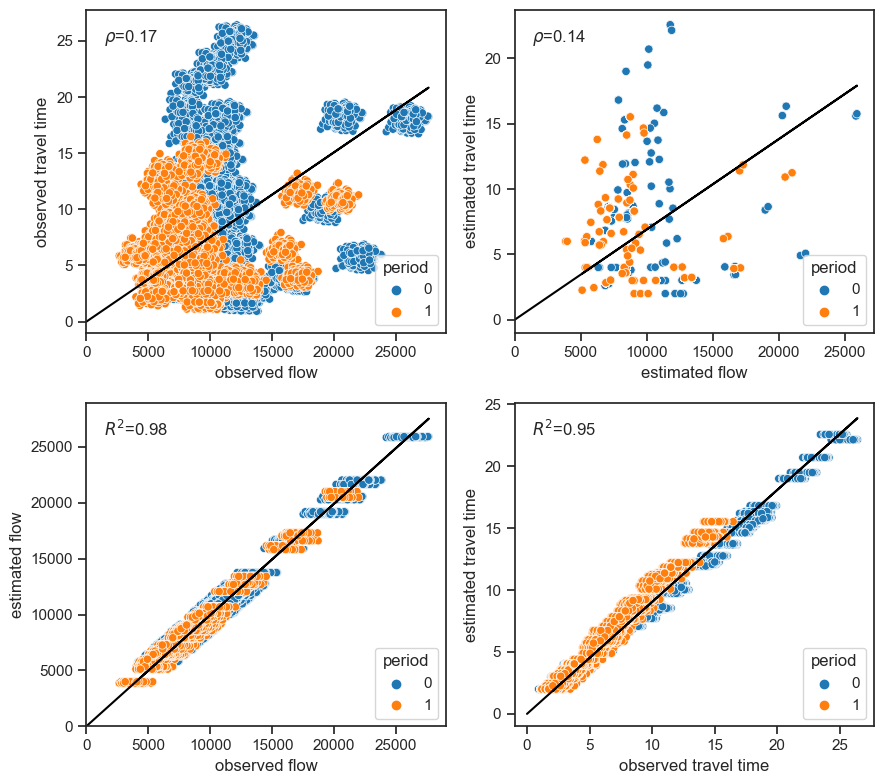

In [84]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        all_metrics = False)

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)
    ax.legend(loc='lower right', title = 'period')

axs[1,1].set_xlim(xmin=-1)


plt.show()

## Write predictions

In [ ]:
# TODO: predictions are not supported for tvodlulpe model yet

In [ ]:
predictions = pd.DataFrame({'link_key': list(network.links_keys) * Y_train.shape[0],
                            'observed_traveltime': Y_train[:, :, 0].numpy().flatten(),
                            'observed_flow': Y_train[:, :, 1].numpy().flatten()})

# predictions['period'] = df.period

# for model in models.values():
#
#     # model = odlulptte
#
#     predicted_flows = model.predicted_flow()
#     predicted_traveltimes = model.traveltimes()
#
#     predictions['predicted_traveltime_' + model_key] = np.tile(predicted_traveltimes, (Y_train.shape[0], 1)).flatten()
#     predictions['predicted_flow_' + model_key] = np.tile(predicted_flows, (Y_train.shape[0], 1)).flatten()
#
# predictions.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_train_predictions_{network_name}.csv")

## Write with estimation results

In [ ]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
val_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

## Summary of models parameters

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [ ]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [ ]:
results_losses[['model'] + loss_columns].round(1)

## Plot of convergence toward true rr across models

In [ ]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])

    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]


fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

utility_true_values = models['tvodlulpe'].utility.true_values

ax.hlines(y=compute_rr(utility_true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'true ratio', color = 'black')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, _XTICKS_SPACING))

plt.legend(loc = 'upper left')
#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Plot of total trips by hour for all models

In [ ]:
total_trips = compute_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys)

fig, ax = plt.subplots(figsize=(5, 4))

total_trips_by_hour_models = compute_total_trips_models(models = models, period_feature = period_feature,
                                                        period_keys = period_keys)

g = sns.pointplot(data= total_trips_by_hour_models, x=period_feature, y='total_trips', ax=ax, hue='model')

plt.ylabel('total trips', fontsize=12)

ax.set_xticklabels([0,1])
ax.set_xlabel('period')
ax.legend()

# plt.legend(loc='lower left')
plt.legend(loc='upper right', title = 'model')

plt.show()

In [ ]:
print(total_trips)

In [ ]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

In [ ]:
total_trips.groupby('model')[['total_trips']].sum().round(1)

## Global runtime

In [ ]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')